In [ ]:
# pip install tensorflow

In [ ]:
import tensorflow as tf

from tensorflow.keras.applications import ResNet50  #ResNet Pretrained Model
incept_model = ResNet50(include_top=True)


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import pickle
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from keras.layers.merge import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from tensorflow.keras.models import Sequential, Model

In [ ]:
#Model for extracting the image features
from keras.models import Model
last = incept_model.layers[-2].output
modele = Model(inputs = incept_model.input,outputs = last)
modele.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

# Image Preprocessing

In [ ]:
#Extracting features from image and storing that in image_feature
input_image=np.load("/content/drive/MyDrive/DL_Project_files/image_data_task3.npy",allow_pickle=True)
image_feature=[]
for img in input_image:
  image_feature.append(modele.predict(img.reshape(1,224,224,3)).reshape(2048,))

In [ ]:
len(image_feature)

1000

In [ ]:
img_new = input_image[0].reshape(1,224,224,3)
print(img_new.shape)

(1, 224, 224, 3)


# Descriptions Preprocessing

In [ ]:
#Load descriptions
with open("/content/drive/MyDrive/DL_Project_files/labels_desc.txt", "rb") as fp:   # Unpickling
    input_desc = pickle.load(fp)
# input_desc

In [ ]:
#Adding of "SOS" and "EOS"
def preprocessed(txt):
    modified = txt.lower()
    modified = 'startofseq ' + modified + ' endofseq'
    return modified

temp=[]
modified_input_desc=[]
for elist in input_desc:
  i=0
  for sent in elist:
    if i<5:
      new_sent=preprocessed(sent)
      temp.append(new_sent)
      i+=1
    else:
      break
  modified_input_desc.append(temp)
  temp=[]
  

In [ ]:
# modified_input_desc

In [ ]:
#create vocab
count_words={}
count=1
for elist in modified_input_desc:
  for sent in elist:
    for word in sent.split():
      if word not in count_words:
        count_words[word]=count
        count+=1


In [ ]:
len(count_words)

3901

In [ ]:
#Converting strings into integers
word_encoded=[]
sent_encoded=[]
list_encoded=[]
for elist in modified_input_desc:
  for sent in elist:
    for word in sent.split():
      word_encoded.append(count_words[word])
    sent_encoded.append(word_encoded)
    word_encoded=[]
  list_encoded.append(sent_encoded)
  sent_encoded=[]

In [ ]:
# list_encoded

In [ ]:
#Getting maximum length of sentences
MAX_LEN = 0
for elist in list_encoded:
  for sent in elist:
        if len(sent) > MAX_LEN:
            MAX_LEN = len(sent)
            # print(v)

In [ ]:
print(MAX_LEN)

26


# Generator function for generating of inputs and outputs for LSTM model 

In [ ]:
# temp=[]
# for i in range(136):
#   temp.append(list_encoded[i])

In [ ]:
# temp

In [ ]:
# image_feature = np.array([0.276819  , 2.1145566 , 0.1837542 , 0.06818397, 0.00342374,1.1057582 ])
# list_encoded=[[[1,2,3,4,5,6]]]
# MAX_LEN=10

In [ ]:
VOCAB_SIZE = len(count_words)
# VOCAB_SIZE=10
def generator(photo, caption):
  X = []
  y_in = []
  y_out = []
  k=0
  for elist in caption:
    for sent in elist:
      for i in range(len(sent)):
        X.append(photo[k])
        in_seq= [sent[:i]]
        out_seq = sent[i]

        in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
        out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE+1)[0]

        y_in.append(in_seq)
        y_out.append(out_seq)
    k+=1
  return X, y_in, y_out
    
    

In [ ]:
X, y_in, y_out = generator(image_feature, list_encoded)

In [ ]:
len(X), len(y_in), len(y_out)

(54185, 54185, 54185)

In [ ]:
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')



In [ ]:
X.shape, y_in.shape, y_out.shape

((54185, 2048), (54185, 26), (54185, 3902))

# Model

In [ ]:
embedding_size = 128
max_len = MAX_LEN
vocab_size = len(count_words)+1

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 26, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 26, 128)           499456    
_________________________________________________________________
lstm (LSTM)                  (None, 26, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 26, 128)           32896     
Total params: 926,592
Traina

In [ ]:
model.fit([X, y_in], y_out, batch_size=512, epochs=50)

Epoch 1/50
106/106 [==============================] - 20s 138ms/step - loss: 5.5626 - accuracy: 0.1382
Epoch 2/50
106/106 [==============================] - 15s 137ms/step - loss: 4.9326 - accuracy: 0.2200
Epoch 3/50
106/106 [==============================] - 15s 137ms/step - loss: 4.7095 - accuracy: 0.2389
Epoch 4/50
106/106 [==============================] - 15s 138ms/step - loss: 4.5288 - accuracy: 0.2452
Epoch 5/50
106/106 [==============================] - 14s 136ms/step - loss: 4.3222 - accuracy: 0.2552
Epoch 6/50
106/106 [==============================] - 15s 138ms/step - loss: 4.0785 - accuracy: 0.2976
Epoch 7/50
106/106 [==============================] - 15s 138ms/step - loss: 3.9378 - accuracy: 0.3057
Epoch 8/50
106/106 [==============================] - 15s 137ms/step - loss: 3.8007 - accuracy: 0.3237
Epoch 9/50
106/106 [==============================] - 15s 138ms/step - loss: 3.7077 - accuracy: 0.3359
Epoch 10/50
106/106 [==============================] - 14s 136ms/step - l

In [ ]:
model.save('model.h5')
model.save_weights('mine_model_weights.h5')
np.save('vocab.npy', count_words)

#Prediction

In [ ]:
#Inverse dictionary
inv_dict = {v:k for k, v in count_words.items()}

In [ ]:
import cv2
def preprocess_image(x):
    
    test_img_path = input_image[x]

    # test_img = cv2.imread(test_img_path)
    # test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    test_img = cv2.resize(test_img_path, (224,224))

    test_img = np.reshape(test_img, (1,224,224,3))
    test_feature = modele.predict(test_img).reshape(1,2048)
    
    return test_feature

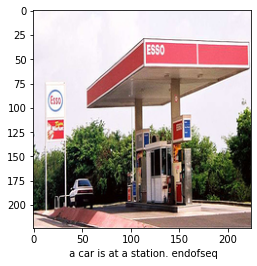

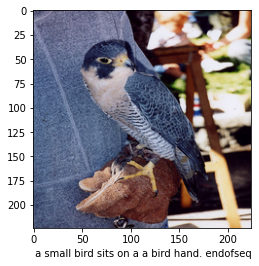

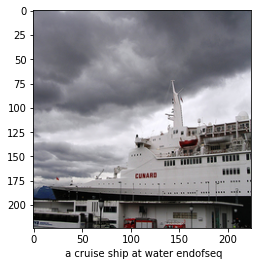

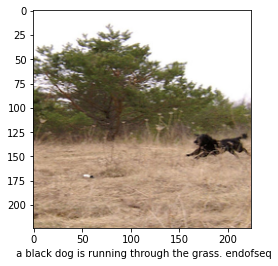

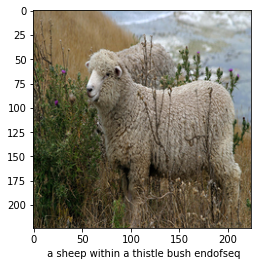

In [ ]:

# no = np.random.randint(1500,7000,(1,1))[0,0]
# test_feature = modele.predict(getImage(no)).reshape(1,2048)
index=[600,701,200,900,500]
import matplotlib.pyplot as plt
for ind in index:
  test_img_path = input_image[ind]
# test_img1 = cv2.imread(test_img_path)
# test_img1 = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

  test_img = preprocess_image(ind)

  text_inp = ['startofseq']

  count = 0
  caption = ''
  while count < 25:
    count += 1

    encoded = []
    for i in text_inp:
        encoded.append(count_words[i])

    encoded = [encoded]

    encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)


    prediction = np.argmax(model.predict([test_img, encoded]))

    sampled_word = inv_dict[prediction]

    caption = caption + ' ' + sampled_word
        
    if sampled_word == 'endofseq':
        break

    text_inp.append(sampled_word)


    
  plt.figure()
  plt.imshow(test_img_path) 
  plt.xlabel(caption)